# Lab2

In [1013]:
import numpy as np
import matplotlib.pyplot as plt

## generate data

In [1014]:
# In real world, you cannot learn how the data was generated. So do not rely on this function when coding your lab.
def generate_data(dim, num):
    x = np.random.normal(0, 10, [num, dim])
    coef = np.random.uniform(-1, 1, [dim, 1])
    pred = np.dot(x, coef)
    pred_n = (pred - np.mean(pred)) / np.sqrt(np.var(pred))
    label = np.sign(pred_n)
    mislabel_value = np.random.uniform(0, 1, num)
    mislabel = 0
    for i in range(num):
        if np.abs(pred_n[i]) < 1 and mislabel_value[i] > 0.9 + 0.1 * np.abs(pred_n[i]):
            label[i] *= -1
            mislabel += 1
    return x, label, mislabel/num

## write your model class

In [1015]:
# you can do anything necessary about the model
class SVM1:
    ##参考《统计学习方法》中7.4节SMO方法，
    # 变量的选取方式可以保证每次有足够的下降
    def __init__(self, dim, C=100):
        self.dim=dim
        self.coe=np.zeros(self.dim)
        self.C=C
        self.bias=0

    def fit(self, X, y):
        #SMO方法
        y=np.squeeze(y)
        n=y.size
        K=np.dot(X,X.T) #X行向量的度量矩阵
        i_choose=np.arange(n)
        a=np.zeros(n)
        g=np.zeros(n)
        global b
        global goal
        b=self.bias
        C=5000
        for itr in range(n):
            g[itr]= np.dot(a*y.T,K[itr])+b
        E=g-y
        goal= 0.5*((a*y).T)@K@ (a*y)-a.sum()

        def select1(S=i_choose):
            #在指定下标集合中寻找第一个变量（主循环中选过的不会再被选择）
            #并判断停机条件
            tol=1e-5 #指定误差
            mymax_num1=0
            mymax_num2=0
            for i in S:
                if 0<a[i]<C:
                    if abs(y[i]*g[i]-1) > tol:
                        if abs(y[i]*g[i]-1)>mymax_num2:
                            mymax_index2=i
                            mymax_num2=abs(y[i]*g[i]-1)
                if mymax_num2 !=0:
                    break
                elif a[i]==0:
                    if y[i]*g[i]-1<-tol:
                        if abs(y[i]*g[i]-1)>mymax_num1:
                            mymax_index1=i
                            mymax_num1=abs(y[i]*g[i]-1)
                elif a[i]==C:
                    if y[i]*g[i]-1>tol:
                        if y[i]*g[i]-1>mymax_num1:
                            mymax_index1=i
                            mymax_num1=y[i]*g[i]-1
            if mymax_num2!=0 :
                return mymax_index2
            elif mymax_num1 !=0:
                return mymax_index1
            else:
                return -1 #达到终止条件返回-1

        def select2_method1(S):
            #第一种方法寻找第二个优化变量选取与第一个变量E差值最大者
            if S.size>0 :
                deltaE=abs(E-E[i])
                max_index2=np.argmax(deltaE)
                if deltaE[max_index2]>1e-5:
                    return max_index2
            else:
                return -1

        def select2_method2(S):
            #第二种方法找第二个优化变量，处于边界上的，或随机选取
            if S.size>0 :
                for k in S:
                    if 1e-5<a[k]<C:
                        return k
                return np.random.choice(S)
            else:
                return -1


        def pre_optimize(i_index,j_index):
            #分为两种情况，如果可以优化则进行优化，否则返回-1不进行优化
            global b
            global goal
            if y[i_index]==y[j_index]:
                L=max(0,a[i_index]+a[j_index]-C)
                H=min(C,a[i_index]+a[j_index])
            else :
                L=max(0,-a[i_index]+a[j_index])
                H=min(C,C-a[i_index]+a[j_index])

            eta=K[i_index][i_index]+K[j_index][j_index]-2*K[i_index][j_index]
            ai_old=a[i_index]
            aj_old=a[j_index]
            if eta!=0:
                aj_temp=a[j_index]+y[j_index]*(E[i_index]-E[j_index])/eta
            else:
                aj_temp=C
            if aj_temp>H:
                aj_new=H
            elif aj_temp<L:
                aj_new=L
            else:
                aj_new=aj_temp
            ai_new=ai_old+y[i_index]*y[j_index]*(aj_old-aj_new)
            if ai_new==ai_old and aj_new==aj_old:
                #这表明并没有下降，返回-1并重新选择变量
                return -1
            else:
                #目标函数会下降，执行优化
                a[i_index]=ai_new
                a[j_index]=aj_new

                #y[i_index]*a[i_index]+y[j_index]*a[j_index]-y[i_index]*ai_old-y[j_index]*aj_old)
                bi=-E[i_index]+y[i_index]*K[i_index][i_index]*(ai_old-a[i_index])+y[j_index]*K[j_index][i_index]*(aj_old-a[j_index])+ b
                bj=-E[j_index]+y[j_index]*K[j_index][j_index]*(aj_old-a[j_index])+y[i_index]*K[i_index][i_index]*(ai_old-a[i_index])+ b

                if 1e-5 < abs(a[i_index]) < C:
                    b=bi
                elif 1e-5 < abs(a[j_index]) < C:
                    b=bj
                else:
                    b=(bi+bj)/2
                for loop in range(n):
                    g[loop]= np.dot(a*y.T,K[loop])+b
                    E[loop]=g[loop]-y[loop]
                goal= 0.5*((a*y).T)@K@ (a*y)-a.sum()
                #pro
                return 0

        i_choose=np.arange(n)
        count=0
        max_itr=n
        while count!=max_itr :
            i=select1(i_choose)
            if i==-1:
                break
            j_choose=np.arange(n)
            j_choose=np.delete(j_choose,np.where(j_choose==i))

            j=select2_method1(j_choose)
            #首先用第一种方法选择j
            if pre_optimize(i,j)==0 :
                #成功优化
                i_choose=np.delete(i_choose,np.where(i_choose==i))
                continue
            else:
                j_choose=np.delete(j_choose,np.where(j_choose==j))
                while 1:
                    #按第二种方法选择j
                    j=select2_method2(j_choose)
                    if pre_optimize(i,j)==0:
                        i_choose=np.delete(i_choose,np.where(i_choose==i))
                        break
                        #成功优化
                    else:
                        j_choose=np.delete(j_choose,np.where(j_choose==j))
            count+=1
        self.bias= b
        self.coe=np.dot((a * y).T, X)


    def predict(self, X):
        #预测结果
        y_predict=np.sign(X@self.coe+self.bias)
        return y_predict

    def evaluate(self,y_real,y_predict):
        #评估正确率
        y_real=np.squeeze(y_real)
        return np.sum(y_real==y_predict)/y_real.size

    def visualization(self,X,y):
        if self.dim==2:
            #对于二维情况可视化
            for i in range(y.size):
                if y[i]==1:
                    plt.scatter(X[i,0],X[i,1],c='y')
                else:
                    plt.scatter(X[i,0],X[i,1],c='r')
            x1=np.array([-20,20])
            x2=-(self.coe[0]*x1+self.bias)/self.coe[1]
            plt.plot(x1,x2,linewidth=3.0,color='g')


In [1016]:
class SVM2:
    #llaozibuxiangzuolcaonimaasdhuiaewvgrb lefjksavbbbbbbbbbbbbbbbbbdskkkkk
    def __init__(self, dim ):
        self.dim=dim
        self.coe=np.zeros(self.dim)
        self.bias=0

    def fit(self, X, y,lr=0.001,max_itr=1000):
        y=np.squeeze(y)
        for i in range(max_itr):
            for j in range(X.shape[0]):
                if y[j] * (np.dot(X[j], self.coe) - self.bias) < 1:
                    self.coe -= lr * (self.coe - y[j]*X[j])
                    self.bias -= lr * y[j]
                else:
                    self.coe -= lr *  self.coe


    def visualization(self,X,y):
        if self.dim==2:
            #对于二维情况可视化
            for i in range(y.size):
                if y[i]==1:
                    plt.scatter(X[i,0],X[i,1],c='y')
                else:
                    plt.scatter(X[i,0],X[i,1],c='r')
            x1=np.array([-20,20])
            x2=-(self.coe[0]*x1+self.bias)/self.coe[1]
            plt.plot(x1,x2,linewidth=3.0)

    def predict(self, X):
        pred = np.dot(X, self.coe) - self.bias
        return np.sign(pred)

    def evaluate(self,y_real,y_predict):
        y_real=np.squeeze(y_real)
        return np.sum(y_real==y_predict)/y_real.size

## data process

In [1017]:
#维数、数据量大小
dim=2
num=2000
X_data, y_data, mislabel = generate_data(dim,num)
training_rate=0.7
test_rate=0.3
# split data
X_training_data= X_data[:int(training_rate * num), :]
y_training_data= y_data[:int(training_rate * num)]
X_test_data= X_data[int(training_rate * num):num, :]
y_test_data= y_data[int(training_rate * num):num]

## construct and train your models

In [1018]:
#model 1
import time
model1 = SVM1(dim,10000)
T1 = time.time()
model1.fit(X_training_data,y_training_data)
T2 =time.time()

## predict and compare your results

In [1019]:
model2 = SVM2(dim)
lr=0.00001
T3 = time.time()
model2.fit(X_training_data,y_training_data,lr)
T4 =time.time()

## predict and compare your results

错标率： 0.032
model 1
accuracy: 0.9633333333333334
Time: 4.66187047958374 s
*******************************
model 2
accuracy: 0.9666666666666667
Time: 7.00047755241394 s
*******************************


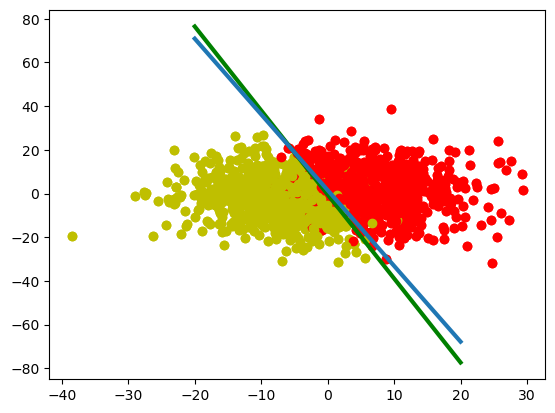

In [1020]:
model1.visualization(X_training_data,y_training_data) #model1 分类直线是绿色
y_predict=model1.predict(X_test_data)
accuracy=model1.evaluate(y_test_data,y_predict)
print("错标率：",mislabel)
print("model 1")
print("accuracy:",accuracy)
print("Time:",T2-T1,"s")
print("*******************************")

model2.visualization(X_training_data,y_training_data)
y_predict=model2.predict(X_test_data)
accuracy=model2.evaluate(y_test_data,y_predict)
print("model 2")
print("accuracy:",accuracy)
print("Time:",T4-T3,"s")
print("*******************************")

# compare each methods